<a href="https://colab.research.google.com/github/lemonyun/keras_study/blob/main/8_3_neural_style_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import keras
keras.__version__

'2.8.0'

# 뉴럴 스타일 트랜스퍼

딥드림 이외에 딥러닝을 사용하여 이미지를 변경하는 또 다른 주요 분야는 뉴럴 스타일 트랜스퍼입니다.

뉴럴 스타일 트랜스퍼는 타깃 이미지의 콘텐츠를 보존하면서 참조 이미지의 스타일을 타깃 이미지에 적용합니다:

# 콘텐츠 손실

타깃 이미지와 생성된 이미지를 사전 훈련된 컨브넷에 주입하여 상위 층의 활성화를 계산합니다. 

컨브넷의 상위 층이 보는 것이 입력 이미지의 콘텐츠라고 가정하면 이미지의 콘텐츠를 보존하는 방법으로 사용할 수 있습니다.

# 스타일 손실

콘텐츠 손실은 하나의 상위 층만 사용하지만 스타일 손실은 여러개의 층을 사용

층의 활성화 출력의 그람 행렬을 스타일 손실로 사용

특성 채널이 10개라면 그람 행렬은 (10, 10)의 크기를 가짐

# 케라스에서 뉴럴 스타일 트랜스퍼 구현하기

1. 스타일 참조 이미지, 타깃 이미지, 생성된 이미지를 위해 VGG19의 층 활성화를 동시에 계산하는 네트워크를 설정합니다.
2. 세 이미지에서 계산한 층 활성화를 사용하여 앞서 설명한 손실 함수를 정의합니다. 이 손실을 최소화하여 스타일 트랜스퍼를 구현할 것입니다.
3. 손실 함수를 최소화할 경사 하강법 과정을 설정합니다.

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
from keras.preprocessing.image import load_img, img_to_array, save_img

# 변환하려는 이미지 경로
target_image_path = './gdrive/MyDrive/datasets/portrait.png'
# 스타일 이미지 경로
style_reference_image_path = './gdrive/MyDrive/datasets/popova.jpg'

# 생성된 사진의 차원
width, height = load_img(target_image_path).size
img_height = 400
img_width = int(width * img_height / height)

In [4]:
import numpy as np
from keras.applications import vgg19

def preprocess_image(image_path):
    img = load_img(image_path, target_size=(img_height, img_width))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

def deprocess_image(x):
    # ImageNet의 평균 픽셀 값을 더합니다
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [13]:
from keras import backend as K

target_image = K.constant(preprocess_image(target_image_path))
style_reference_image = K.constant(preprocess_image(style_reference_image_path))

# 생성된 이미지를 담을 플레이스홀더
combination_image = K.placeholder((1, img_height, img_width, 3)) # 계속 바뀔 데이터

# 세 개의 이미지를 하나의 배치로 합칩니다
input_tensor = K.concatenate([target_image,
                              style_reference_image,
                              combination_image], axis=0)

# 세 이미지의 배치를 입력으로 받는 VGG 네트워크를 만듭니다.
# 이 모델은 사전 훈련된 ImageNet 가중치를 로드합니다
model = vgg19.VGG19(input_tensor=input_tensor,
                    weights='imagenet',
                    include_top=False)
print('모델 로드 완료.')

모델 로드 완료.


In [14]:
input_tensor

<tf.Tensor 'concat:0' shape=(3, 400, 381, 3) dtype=float32>

콘텐츠 손실 함수 정의

In [15]:
def content_loss(base, combination):
    return K.sum(K.square(combination - base))

스타일 손실함수 정의

In [16]:
def gram_matrix(x):
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram


def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_height * img_width
    return K.sum(K.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

총 변위 손실함수 정의 (격자 무늬 가 생기면 손실이 커짐)

In [17]:
def total_variation_loss(x):
    a = K.square(
        x[:, :img_height - 1, :img_width - 1, :] - x[:, 1:, :img_width - 1, :])
    b = K.square(
        x[:, :img_height - 1, :img_width - 1, :] - x[:, :img_height - 1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))

In [19]:
# 층 이름과 활성화 텐서를 매핑한 딕셔너리
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
# 콘텐츠 손실에 사용할 층
content_layer = 'block5_conv2'
# 스타일 손실에 사용할 층
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']
# 손실 항목의 가중치 평균에 사용할 가중치
total_variation_weight = 1e-4
style_weight = 1.
content_weight = 0.025

# 모든 손실 요소를 더해 하나의 스칼라 변수로 손실을 정의합니다
loss = K.variable(0.)
layer_features = outputs_dict[content_layer]
target_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
loss = loss + content_weight * content_loss(target_image_features,
                                      combination_features)
for layer_name in style_layers:
    layer_features = outputs_dict[layer_name]
    style_reference_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_reference_features, combination_features)
    loss += (style_weight / len(style_layers)) * sl
loss += total_variation_weight * total_variation_loss(combination_image)

마지막으로 경사 하강법 단계를 설정합니다. 게티스의 원래 논문에서 L-BFGS 알고리즘을 사용하여 최적화를 수행했으므로 여기에서도 이를 사용하겠습니다. 8.2절의 딥드림 예제와 가장 크게 차이 나는 부분입니다. L-BFGS 알고리즘은 싸이파이에 구현되어 있는데 두 가지 제약 사항이 있습니다.

* 손실 함수의 값과 그래디언트 값을 별개의 함수로 전달해야 합니다.
* 이 함수는 3D 이미지 배열이 아니라 1차원 벡터만 처리할 수 있습니다.

손실 함수의 값과 그래디언트 값을 따로 계산하는 것은 비효율적입니다. 두 계산 사이에 중복되는 계산이 많기 때문입니다. 한꺼번에 계산하는 것보다 거의 두 배 가량 느립니다. 이를 피하기 위해 손실과 그래디언트 값을 동시에 계산하는 Evaluator란 이름의 파이썬 클래스를 만들겠습니다. 처음 호출할 때 손실 값을 반환하면서 다음 호출을 위해 그래디언트를 캐싱합니다.

In [20]:
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
# 손실에 대한 생성된 이미지의 그래디언트를 구합니다
grads = K.gradients(loss, combination_image)[0]

# 현재 손실과 그래디언트의 값을 추출하는 케라스 Function 객체입니다
fetch_loss_and_grads = K.function([combination_image], [loss, grads])


class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        x = x.reshape((1, img_height, img_width, 3))
        outs = fetch_loss_and_grads([x])
        loss_value = outs[0]
        grad_values = outs[1].flatten().astype('float64')
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator()

마지막으로 싸이파이 L-BFGS 알고리즘을 사용하여 경사 하강법 단계를 수행합니다. 알고리즘 반복마다 생성된 이미지를 저장합니다(여기에서는 한 번 반복이 경사 하강법 단계 20번입니다):

In [21]:
from scipy.optimize import fmin_l_bfgs_b
import time

result_prefix = 'style_transfer_result'
iterations = 20

# 뉴럴 스타일 트랜스퍼의 손실을 최소화하기 위해 생성된 이미지에 대해 L-BFGS 최적화를 수행합니다
# 초기 값은 타깃 이미지입니다
# scipy.optimize.fmin_l_bfgs_b 함수가 벡터만 처리할 수 있기 때문에 이미지를 펼칩니다.
x = preprocess_image(target_image_path)
x = x.flatten()
for i in range(iterations):
    print('반복 횟수:', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x,
                                     fprime=evaluator.grads, maxfun=20)
    print('현재 손실 값:', min_val)
    # 생성된 현재 이미지를 저장합니다
    img = x.copy().reshape((img_height, img_width, 3))
    img = deprocess_image(img)
    fname = result_prefix + '_at_iteration_%d.png' % i
    save_img(fname, img)
    end_time = time.time()
    print('저장 이미지: ', fname)
    print('%d 번째 반복 완료: %ds' % (i, end_time - start_time))

반복 횟수: 0
현재 손실 값: 8162770000.0
저장 이미지:  style_transfer_result_at_iteration_0.png
0 번째 반복 완료: 29s
반복 횟수: 1
현재 손실 값: 3111880700.0
저장 이미지:  style_transfer_result_at_iteration_1.png
1 번째 반복 완료: 15s
반복 횟수: 2
현재 손실 값: 1952415100.0
저장 이미지:  style_transfer_result_at_iteration_2.png
2 번째 반복 완료: 15s
반복 횟수: 3
현재 손실 값: 1528286700.0
저장 이미지:  style_transfer_result_at_iteration_3.png
3 번째 반복 완료: 15s
반복 횟수: 4
현재 손실 값: 1276209000.0
저장 이미지:  style_transfer_result_at_iteration_4.png
4 번째 반복 완료: 15s
반복 횟수: 5
현재 손실 값: 1110586100.0
저장 이미지:  style_transfer_result_at_iteration_5.png
5 번째 반복 완료: 15s
반복 횟수: 6
현재 손실 값: 979626560.0
저장 이미지:  style_transfer_result_at_iteration_6.png
6 번째 반복 완료: 15s
반복 횟수: 7
현재 손실 값: 894069440.0
저장 이미지:  style_transfer_result_at_iteration_7.png
7 번째 반복 완료: 15s
반복 횟수: 8
현재 손실 값: 834744640.0
저장 이미지:  style_transfer_result_at_iteration_8.png
8 번째 반복 완료: 15s
반복 횟수: 9
현재 손실 값: 776824200.0
저장 이미지:  style_transfer_result_at_iteration_9.png
9 번째 반복 완료: 15s
반복 횟수: 10
현재 손실 값: 733178900.0
저장 

In [22]:
from matplotlib import pyplot as plt

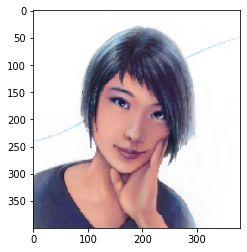

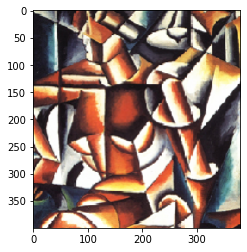

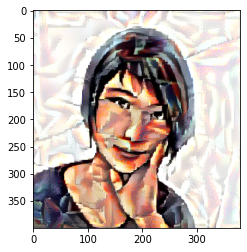

In [23]:
# 콘텐츠 이미지
plt.imshow(load_img(target_image_path, target_size=(img_height, img_width)))
plt.figure()

# 스타일 이미지
plt.imshow(load_img(style_reference_image_path, target_size=(img_height, img_width)))
plt.figure()

# 생성된 이미지
plt.imshow(img)
plt.show()

이 기법은 이미지의 텍스처를 바꾸거나 텍스처를 전이한 것임을 기억하세요. 스타일 이미지의 텍스처가 두드러지고 비슷한 패턴이 많을 때 잘 작동합니다. 또 콘텐츠 타깃을 알아 보기 위해 수준 높은 이해가 필요하지 않을 때 잘 작동합니다. 일반적으로 인물 사진의 스타일을 다른 인물 사진으로 옮기는 것같이 아주 추상적인 기교는 만들지 못합니다. 이 알고리즘은 AI 보다는 고전적인 시그널 처리에 가깝기 때문에 마술 같은 결과를 기대하지 마세요!

스타일 트랜스퍼 알고리즘은 **느리지만 간단한 변환을 수행하기 때문에 작고 빠른 컨브넷을 사용해 학습할 수 있습니다.** 물론 적절한 양의 훈련 데이터가 있어야 합니다. 먼저 고정된 스타일 참조 이미지에 대해서 여기에서 소개한 방법으로 입력-출력 훈련 샘플을 많이 생성합니다. 그다음 이 스타일 변환을 학습하는 간단한 컨브넷을 훈련하면 스타일 트랜스퍼를 빠르게 수행할 수 있습니다. 이런 모델을 만들면 어떤 이미지가 주어졌을 때 순식간에 스타일을 바꿀 수 있습니다. 그냥 이 작은 컨브넷을 통과시키면 됩니다.